In [54]:
import data_analysis
import os
from shutil import copy
import pickle
import pandas as pd
import math
import matplotlib.pyplot as plt

In [3]:
# 0_label: suitable for children
# 1_label: not suitable for children 

def get_percentage_of_labeled_data(labeled_0_words_count, labeled_1_words_count):
    """
    Function to get the percentage of a labeled dataset out of the total corpus
    :param labeled_0_words_count: count of words in label_0 docs
    :param labeled_1_words_count: count of words in label_1 docs
    :return: percentage_labeled_0, percentage_labeled_1
    """
    total = labeled_0_words_count + labeled_1_words_count
    return float("%.3f" % (labeled_0_words_count / total)), \
           float("%.3f" % (labeled_1_words_count / total))


def get_average_docs_length(docs_info_lst):
    """
    Function to get the average length of 0, 1 labeled docs in terms of words
    :param docs_info_lst: lst of tuples of the form [(words_count, movie_id, rating), ..]
    :return: average_docs_length 
    """
    total = 0
    for file in docs_info_lst:
        total += file[0]
    return int(total / len(docs_info_lst))


def get_dict_of_words_totalCount_docsCount(data_dictionary, label):
    """ 
    Function to make a dict that represents words in each labeled data
    :param data_dictionary: dict of the form {"label_#: {"movie_id": ["w_0", "w_1", ...]}, .. }
           label: string, 0_label or 1_label
    :return: words_dict: a dict of the form: 
                        {word_0: [number_of_total_occurrence_in_a_labeled_data, 
                                 {movie_0: [number_of_occurrence_in_movie_0, 
                                  ... }
                                ]
                         ...
                         }         
    """
    words_dict = {}
    # For each movie
    for movie_name in data_dictionary[label]:
        # For each word in this movie
        for word in data_dictionary[label][movie_name]:
            # If word is already exists in the dict
            if word in words_dict:
                # Increase the count of this word in teh total count among all docs
                words_dict[word][0] += 1

                # Increasing the count of this word in each doc, "{movie_0: [doc_1_count, ..], ..}"
                if movie_name in words_dict[word][1]:
                    #
                    (words_dict[word][1])[movie_name] += 1
                else:
                    # Initialize
                    (words_dict[word][1])[movie_name] = 1
            # If word is not found in the dict before, initialize
            else:
                words_dict[word] = [1, {movie_name: 1}]
    return words_dict

def out_pickle(pickle_path, pick_name, variable_name):
    """
    Function that pickles out a variable
    :param pickle_path: in pickle's path
    :param pick_name: in pickle's name 'without .pkl extension'
    :param variable_name: the variable to be pickled out
    :return: nothing
    """
    with open(pickle_path + pick_name + ".pkl", "wb") as pkl:
        pickle.dump(variable_name, pkl)

def in_pickle(pickle_path, pick_name):
    """
    Function that pickles in a variable
    :param pickle_path: in pickle's path
    :param pick_name: in pickle's name 'without .pkl extension'
    :return: the variable that contains pickled in data
    """
    with open(pickle_path + pick_name + ".pkl", "rb") as pkl:
        return pickle.load(pkl)
    
#plots
def plot_pie_char_and_save_it(list_of_slice_values, list_of_slice_names, file_path_name):
    plt.figure(figsize=(10,10))
    plt.pie(list_of_slice_values, labels=list_of_slice_names, startangle=90, autopct='%.1f%%')
    plt.savefig(file_path_name)
    plt.show()


In [4]:
%%time
# {"label_#: {"movie_id": ["w_0", "w_1", ...]}, .. }
data_dictionary = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'data_dictionary_before_removing_frequent_words')

Wall time: 5.24 s


In [6]:
'''{word_0: [number_of_total_occurrence_in_a_labeled_data, 
                                 {movie_0: [number_of_occurrence_in_movie_0, 
                                  ... }
                                ]
                         ...
                         }'''
dict_of_0_label_words = get_dict_of_words_totalCount_docsCount(data_dictionary, "0_label")
dict_of_1_label_words = get_dict_of_words_totalCount_docsCount(data_dictionary, "1_label")

In [9]:
pandas_dict = {}

pandas_dict["rating"] = []
pandas_dict ["movie_id"] = []
pandas_dict ["movie_words"] = []

In [10]:
%%time
for label in list(data_dictionary.keys())[:2]:
    for movie_name in data_dictionary[label]:
        pandas_dict["rating"].append(label)
        pandas_dict["movie_words"].append(data_dictionary[label][movie_name])
        pandas_dict["movie_id"].append(movie_name)

Wall time: 9.97 ms


In [11]:
# row: index
# columns : rating, movie_id, [word_1, word_2, ...]
data_frames = pd.DataFrame(data=pandas_dict,
                           columns=["rating", "movie_id", "movie_words"])

In [9]:
%%time
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'dict_of_0_label_words', dict_of_0_label_words)
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'dict_of_1_label_words', dict_of_1_label_words)
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'pandas_data_frame', data_frames)

CPU times: user 8.18 s, sys: 892 ms, total: 9.07 s
Wall time: 10.8 s


In [5]:
data_frames = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'pandas_data_frame')
dict_of_0_label_words = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'dict_of_0_label_words')
dict_of_1_label_words = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'dict_of_1_label_words')

In [6]:

model = in_pickle('C:/Users/Abdo/Documents/word2vec models/', 'word2vecModel_glove_6b_200d')


C:\Users\Abdo\PycharmProjects\final_project_1\venv\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
# wCount_movieId_rating_lst: list of tuples: [ (words_count, movie_id, rating), ..... ] of the corpus "both labels"
wordCount_movieId_rating_lst = []

for index, row in data_frames.iterrows():
    movie_id = row["movie_id"]
    rating = row["rating"]
    length = len(row["movie_words"])
    wordCount_movieId_rating_lst.append((length, movie_id, rating))
    wordCount_movieId_rating_lst.sort()

In [8]:
# Number of 0 & 1 labeled docs
number_of_0_label_docs = len(data_dictionary["0_label"])
number_of_1_label_docs = len(data_dictionary["1_label"])

# percentage of 0, 1 labeled docs among the whole corpus
percentage_0_labeled_docs, percentage_1_labeled_docs = \
    get_percentage_of_labeled_data(number_of_0_label_docs, number_of_1_label_docs)

# find the max, and min number of words among all documents
min_number_of_words = wordCount_movieId_rating_lst[0]
max_number_of_words = wordCount_movieId_rating_lst[-1]

# average docs length in terms of words 
average_docs_length = get_average_docs_length(wordCount_movieId_rating_lst)

print("number_of_0_label_docs ",number_of_0_label_docs)
print("number_of_1_label_docs ",number_of_1_label_docs)
print("percentage_0_labeled_docs ",percentage_0_labeled_docs)
print("percentage_1_labeled_docs ",percentage_1_labeled_docs)
print("average_docs_length ",average_docs_length)
print("min_number_of_words ", min_number_of_words)
print("max_number_of_words ", max_number_of_words)


number_of_0_label_docs  1577
number_of_1_label_docs  4734
percentage_0_labeled_docs  0.25
percentage_1_labeled_docs  0.75
average_docs_length  3275
min_number_of_words  (54, 'PG_54', '0_label')
max_number_of_words  (13765, 'PG-13_5058', '1_label')


In [9]:

# from the word2vec model
vocabulary = set(model.wv.vocab)

C:\Users\Abdo\PycharmProjects\final_project_1\venv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
label_0_keys = list(dict_of_0_label_words.keys())
label_1_keys = list(dict_of_1_label_words.keys())

In [11]:
(len(label_0_keys), len(label_1_keys))

(76587, 148973)

In [12]:
inappropriate_words = []
# key : inappropriate_word
#value : [total_occurences, {movie_id: occurenes_in_movie,movie_id: occurenes_in_movie,.....}]
inappropriate_words_in_0_label_movies = {}

In [13]:
file = open("C:/Users/Abdo/Project/Notes/inappropriate_words.txt","r")
for word in file.readlines():
    inappropriate_words.append(word.replace("\n",""))

In [29]:
#fill the values 
for inappropriate_word in inappropriate_words:
    # if word exist in dict
    if inappropriate_word in dict_of_0_label_words:
        # [0,[]] = [total_occurrence_of_word, {movie_name:occurrences_of_word_in_it, ...}]
        inappropriate_words_in_0_label_movies[inappropriate_word] = dict_of_0_label_words[inappropriate_word]
    else:
        #initialize the value 
        inappropriate_words_in_0_label_movies[inappropriate_word] = [0,[]]

In [17]:

out_pickle('C:/Users/Abdo/Project/pickle_files/', 'inappropriate_words_in_0_label_movies', inappropriate_words_in_0_label_movies)

In [14]:
inappropriate_words_in_0_label_movies = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'inappropriate_words_in_0_label_movies')

In [15]:
#total_words_in_all_movies
all_text_words = set(dict_of_1_label_words.keys())
all_text_words.update(set(dict_of_0_label_words.keys()))

In [16]:
common_words = set(dict_of_1_label_words.keys()).intersection(set(dict_of_0_label_words.keys()))

In [17]:
percentage_of_common_words = len(common_words)/len(all_text_words)

In [18]:
unique_words_in_0_label = set(dict_of_0_label_words.keys()).difference(common_words)
unique_words_in_1_label = set(dict_of_1_label_words.keys()).difference(common_words)

In [19]:
# key : word
# value : [ [total frequency, {movie_name: frequency_of_word_in_movie},..] , .... ] 
frequency_of_unique_words_in_0_label = {}
frequency_of_unique_words_in_1_label = {}

In [20]:
# takes the label name and a dictionary of the shape, to fill:
# key : word
# value : [ [total frequency, {movie_name: frequency_of_word_in_movie},..] , .... ] 
def get_frequency_of_uinque_words_in_labeled_documents(label_name, unique_words_of_label,frequency_of_unique_words_of_label):
    for movie_name in data_dictionary[label_name]:
        for word in data_dictionary[label_name][movie_name]:
            # if this word is a unique of word of this label, else continue to next iteration
            if word in unique_words_of_label:
                # if it already exist, update its value
                if word in frequency_of_unique_words_of_label:
                    # increase the total frequency by one
                    frequency_of_unique_words_of_label[word][0] += 1
                    # if the movie_name exist in the frequency_of_unique_words_of_label[1] dict
                    if movie_name in frequency_of_unique_words_of_label[word][1]:
                        frequency_of_unique_words_of_label[word][1][movie_name] +=1
                    # if not, initialize it to 1
                    else:
                        frequency_of_unique_words_of_label[word][1][movie_name] = 1
                # add the word to dict if it doesn't exist
                else:
                    frequency_of_unique_words_of_label[word] = [1, {movie_name:1}]

In [21]:
get_frequency_of_uinque_words_in_labeled_documents("0_label", unique_words_in_0_label, frequency_of_unique_words_in_0_label)
get_frequency_of_uinque_words_in_labeled_documents("1_label", unique_words_in_1_label, frequency_of_unique_words_in_1_label)

In [ ]:
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'frequency_of_unique_words_in_0_label', frequency_of_unique_words_in_0_label)
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'frequency_of_unique_words_in_1_label', frequency_of_unique_words_in_1_label)

In [74]:
frequency_of_unique_words_in_0_label = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'frequency_of_unique_words_in_0_label')
frequency_of_unique_words_in_1_label = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'frequency_of_unique_words_in_1_label')

In [25]:
# [(frequency, word), ....]
list_of_uinque_0_label_words_and_frequencies = []
list_of_uinque_1_label_words_and_frequencies = []

In [26]:
for word in frequency_of_unique_words_in_0_label:
    list_of_uinque_0_label_words_and_frequencies.append( (frequency_of_unique_words_in_0_label[word][0], word) )
    
for word in frequency_of_unique_words_in_1_label:
    list_of_uinque_1_label_words_and_frequencies.append( (frequency_of_unique_words_in_1_label[word][0], word) )

In [27]:
list_of_uinque_0_label_words_and_frequencies.sort()
list_of_uinque_1_label_words_and_frequencies.sort()

In [81]:
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'list_of_uinque_0_label_words_and_frequencies', list_of_uinque_0_label_words_and_frequencies)
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'list_of_uinque_1_label_words_and_frequencies', list_of_uinque_1_label_words_and_frequencies)

In [ ]:
list_of_uinque_0_label_words_and_frequencies = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'list_of_uinque_0_label_words_and_frequencies')
list_of_uinque_1_label_words_and_frequencies = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'list_of_uinque_1_label_words_and_frequencies')

In [28]:
# the percentage of bad words in every 0_labeled movie
# key : movie_id
# value : percentage_of_bad_words
percentage_of_bad_words_in_0_labeld_movies = {}

In [29]:
# find the number of bad words in each 0_label movie
for movie_name in data_dictionary["0_label"]:
    movie_words_count = len(data_dictionary["0_label"][movie_name])
    number_of_bad_words = 0
    for bad_word in inappropriate_words_in_0_label_movies:
        # if the movie has this bad word
        if movie_name in inappropriate_words_in_0_label_movies[bad_word][1]:
            # increase the movie total number of bad words by how many time this bad word occurred in this movie
            number_of_bad_words += inappropriate_words_in_0_label_movies[bad_word][1][movie_name]
    percentage_of_bad_words_in_0_labeld_movies[movie_name] = number_of_bad_words/movie_words_count

In [99]:
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'percentage_of_bad_words_in_0_labeld_movies', percentage_of_bad_words_in_0_labeld_movies)

In [26]:
percentage_of_bad_words_in_0_labeld_movies = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'percentage_of_bad_words_in_0_labeld_movies')

In [30]:
# turn the dictionary into list to sort it
# [ (percentage_of_bad_words_in_movie, movie_name) ]
percentage_of_bad_words_in_0_labeld_movies_list = []
for movie_name in percentage_of_bad_words_in_0_labeld_movies:
    percentage_of_bad_words_in_0_labeld_movies_list.append\
        ( (percentage_of_bad_words_in_0_labeld_movies[movie_name], movie_name) )

In [31]:
percentage_of_bad_words_in_0_labeld_movies_list.sort()

In [34]:
non_english_words = all_text_words.difference(vocabulary)

In [35]:
# key : label
# value : {movie_id : percentage_of_non_english_words, ..} 
percentage_of_non_english_words_in_movies = {"0_label":{}, "1_label":{}}

In [36]:
#initlize all keys' values to zero
for movie_name in data_dictionary["0_label"]:
    percentage_of_non_english_words_in_movies["0_label"][movie_name] = 0

for movie_name in data_dictionary["1_label"]:
    percentage_of_non_english_words_in_movies["1_label"][movie_name] = 0

In [39]:
# takes the label as input
# fills dict_of_label_words with movie_id : percentage_of_non_english_words in it
def count_non_english_words_in_label(label, dict_of_label_words):
    # for every word in the label's dictionary
    for word in dict_of_label_words:
        if word in non_english_words:
            # for each movie in this label that has this word
            for movie_name in (dict_of_label_words[word][1]).keys():
                percentage_of_non_english_words_in_movies[label][movie_name] += dict_of_label_words[word][1][movie_name]
    
    #divide the count of non-english words on the total number of words in the movie
    for movie_name in data_dictionary[label]:
        percentage_of_non_english_words_in_movies[label][movie_name] /= (len(data_dictionary[label][movie_name]))

In [40]:
count_non_english_words_in_label("0_label", dict_of_0_label_words)
count_non_english_words_in_label("1_label", dict_of_1_label_words)

In [41]:
# [ (percentage_of_non_english_words, label, movie_name), ......]
percentage_of_non_english_words_list = []

In [42]:
# turn the percentage_of_non_english_words_in_movies dictionary to a list to be able to sort it
for label in percentage_of_non_english_words_in_movies.keys():
    for movie_name in percentage_of_non_english_words_in_movies[label]:
        percentage_of_non_english_words_list.append( 
            (percentage_of_non_english_words_in_movies[label][movie_name],
            label, movie_name)
        )

In [43]:
percentage_of_non_english_words_list.sort(reverse=True)

In [48]:
out_pickle('C:/Users/Abdo/Project/pickle_files/', 'percentage_of_non_english_words_list', percentage_of_non_english_words_list)

In [ ]:
percentage_of_non_english_words_list = in_pickle('C:/Users/Abdo/Project/pickle_files/', 'percentage_of_non_english_words_list')

In [59]:
slice_values_of_chart = []
slice_names_of_chart = []
for x,y in list_of_uinque_1_label_words_and_frequencies[-10:]:
    slice_values_of_chart.append(x)
    slice_names_of_chart.append(y)

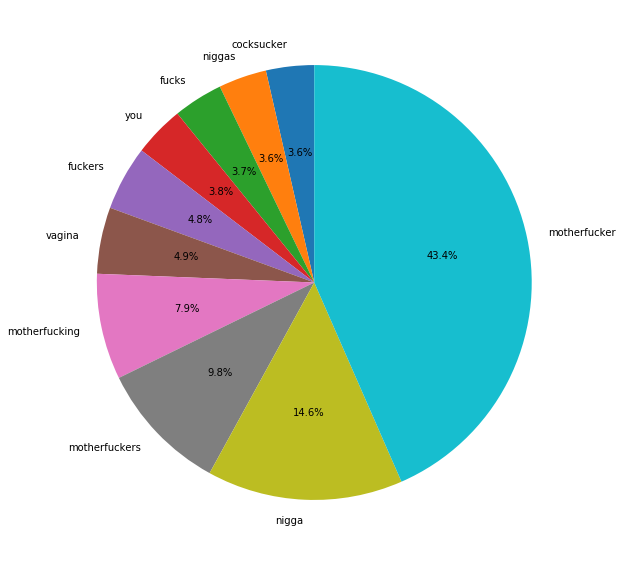

In [60]:
plot_pie_char_and_save_it(slice_values_of_chart,slice_names_of_chart,
              "C:/Users/Abdo/Project/figures/most_frequent_10_words_in_1_label_after_removing_common_words.png")